In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
# ignore this cell if not using local env vars
# # needs to be done before importing transformers
import os
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['HF_HOME'] = "/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads"
os.environ['TRANSFORMERS_CACHE'] = "/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads"


In [3]:
%matplotlib inline


%load_ext autoreload
%autoreload 2


import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import seaborn as sns
import copy

from torch.utils.data import DataLoader
import transformer_lens
import datasets

from load import *

from analysis.load_results import (
    load_probing_experiment_results,
    load_probing_experiment_results_old,
    make_heuristic_probing_results_df
)
from probing_datasets.language_id import NATURAL_LANGS_UNABBREVIATED


from analysis.plots import *




## Load Results

In [4]:


results_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results'
sizes = ['19m', '125m', '350m']
all_results = []
for s in sizes:
    results_dict = load_probing_experiment_results_old(results_dir, 'nat_lang_max_test', 'heuristic_sparsity_sweep', f'pythia-{s}')
    rdf = make_heuristic_probing_results_df(results_dict)
    # add model size to index of rdf
    rdf.index = pd.MultiIndex.from_tuples([
        (s, *t) for t in rdf.index.values],
        names=['model_size', 'feature', 'layer', 'k']
    )
    rdf.rename(index=lambda x: NATURAL_LANGS_UNABBREVIATED[x], level='feature', inplace=True)
    all_results.append(rdf)
rdf = pd.concat(all_results)

In [5]:
rdf#.query('k==1 and model_size=="125m"').sort_values('test_pr_auc', ascending=False).head(10)

test_acc test_balanced_acc test_precision  \
model_size feature layer k                                                 
19m        German  0     1     0.904023          0.943039       0.533274   
                         2     0.940014          0.961082       0.648473   
                         3     0.947862          0.953394       0.687592   
                         4     0.972804          0.976425       0.810544   
                         5     0.973345          0.976548       0.814081   
...                                 ...               ...            ...   
350m       Swedish 23    256   0.999955           0.99979            1.0   
                         512   0.999955           0.99979            1.0   
                         1024  0.999955           0.99979            1.0   
                         2048  0.999955           0.99979            1.0   
                         4096  0.999955           0.99979            1.0   

                              test_recall test_average_precision test_roc_auc  \
model_size feature layer k                                                      
19m        German  0     1       0.993001               0.530309      0.98092   
                         2       0.988061               0.642039     0.995888   
                         3       0.960478               0.664747     0.995784   
                         4       0.981062               0.797269     0.997659   
                         5        0.98065               0.800448     0.997587   
...                                   ...                    ...          ...   
350m       Swedish 23    256      0.99958               0.999625          1.0   
                         512      0.99958               0.999625          1.0   
                         1024     0.99958               0.999625          1.0   
                         2048     0.99958               0.999625          1.0   
                         4096     0.99958               0.999625          1.0   

                                                                        test_fpr  \
model_size feature layer k                                                         
19m        German  0     1     [0.0, 0.0, 0.04290128146684901, 0.042901281466...   
                         2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                         3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                         4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                         5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                                          ...   
350m       Swedish 23    256   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...   
                         512   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...   
                         1024  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                         2048  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...   
                         4096  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        test_tpr  \
model_size feature layer k                                                         
19m        German  0     1     [0.0, 0.5047344586249486, 0.7044051049814739, ...   
                         2     [0.0, 0.21531494442157267, 0.23795800741045697...   
                         3     [0.0, 0.0008233841086867024, 0.034582132564841...   
                         4     [0.0, 0.0004116920543433512, 0.026759983532317...   
                         5     [0.0, 0.0004116920543433512, 0.019761218608480...   
...                                                                          ...   
350m       Swedish 23    256   [0.0, 0.00041981528127623844, 0.96683459277917...   
                         512   [0.0, 0.00041981528127623844, 0.94836272040302...   
                         1024  [0.0, 0.0004198152812762

In [25]:
rdf.query('k==1 and model_size=="19m"').sort_values('test_pr_auc', ascending=False).head(10)

test_acc test_balanced_acc test_precision  \
model_size feature layer k                                              
19m        Italian 4     1  0.999188          0.999544       0.992689   
           Greek   5     1  0.999278          0.999594         0.9936   
           Swedish 4     1  0.998827          0.998974       0.990017   
                   3     1  0.999459          0.998958       0.996647   
           French  3     1  0.998692          0.999086       0.988687   
           Italian 3     1  0.998421          0.998217       0.987849   
           German  3     1  0.998106          0.998936       0.983003   
                   5     1  0.995941          0.996277       0.967239   
           English 5     1  0.999233          0.998705       0.995263   
                   4     1  0.994498          0.995515       0.956687   

                           test_recall test_average_precision test_roc_auc  \
model_size feature layer k                                                   
19m        Italian 4     1         1.0               0.992689     0.999997   
           Greek   5     1         1.0                 0.9936     0.999992   
           Swedish 4     1     0.99916               0.989276     0.999992   
                   3     1    0.998321               0.995154     0.999986   
           French  3     1    0.999592               0.988328     0.999986   
           Italian 3     1    0.997954               0.986054     0.999983   
           German  3     1         1.0               0.983003     0.999954   
                   5     1    0.996706               0.964414     0.999927   
           English 5     1    0.998021               0.993518     0.999593   
                   4     1    0.996833               0.954018     0.999662   

                                                                     test_fpr  \
model_size feature layer k                                                      
19m        Italian 4     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Greek   5     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Swedish 4     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                   3     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           French  3     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Italian 3     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           German  3     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                   5     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           English 5     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                   4     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                     test_tpr  \
model_size feature layer k                                                      
19m        Italian 4     1  [0.0, 0.0004091653027823241, 0.000818330605564...   
           Greek   5     1  [0.0, 0.00040257648953301127, 0.00161030595813...   
           Swedish 4     1  [0.0, 0.00041981528127623844, 0.00083963056255...   
                   3     1  [0.0, 0.00041981528127623844, 0.00209907640638...   
           French  3     1  [0.0, 0.0004084967320261438, 0.004493464052287...   
           Italian 3     1  [0.0, 0.0004091653027823241, 0.003273322422258...   
           German  3     1  [0.0, 0.0004116920543433512, 0.002881844380403...   
                   5     1  [0.0, 0.0004116920543433512, 0.003293536434746...   
           English 5     1  [0.0, 0.000395882818685669, 0.0019794140934283...   
                   4     1  [0.0, 0.9386381631037213, 0.9394299287410927, ...   

                                                         test_precision_curve  \
model_size feature layer k                                                      
19m        Italian 4     1  [0.1102291178062421, 0.11023906179521877, 0.11...   
           Greek   5     

In [26]:
interp_neurons = rdf.query('k==1 and model_size=="19m"').sort_values('test_pr_auc', ascending=False).head(10).reset_index()[['feature', 'layer', 'support']].values
interp_neurons = [(f, l, n[0]) for f, l, n in interp_neurons]
interp_neurons

[('Italian', 4, 627),
 ('Greek', 5, 1434),
 ('Swedish', 4, 230),
 ('Swedish', 3, 1817),
 ('French', 3, 609),
 ('Italian', 3, 533),
 ('German', 3, 343),
 ('German', 5, 894),
 ('English', 5, 395),
 ('English', 4, 179)]

In [27]:
interp_neurons_df = pd.DataFrame(interp_neurons, columns=['feature', 'layer', 'neuron'])[['layer', 'neuron', 'feature']]

In [28]:
from activations.activation_subset import save_neuron_subset_csv
save_neuron_subset_csv(interp_neurons_df, 'pythia-70m', 'monosemantic_language_neurons')

In [29]:
interp_neurons_df

,layer,neuron,feature
0,4,627,Italian
1,5,1434,Greek
2,4,230,Swedish
3,3,1817,Swedish
4,3,609,French
5,3,533,Italian
6,3,343,German
7,5,894,German
8,5,395,English
9,4,179,English


In [13]:
fd = load_feature_dataset('natural_lang_id.pyth.512.-1')

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [14]:
fd

Dataset({
    features: ['lang', 'tokens', 'class_ids', 'probe_indices', 'valid_indices'],
    num_rows: 36952
})

In [15]:
toy_activations = np.random.random(fd['tokens'].shape)

In [20]:
fd['class_ids']

tensor([4, 4, 4,  ..., 6, 6, 6])

In [19]:
model = load_model('pythia-70m')
model.tokenizer.decode(3889)

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


' van'

## Plot overall sparsity curves

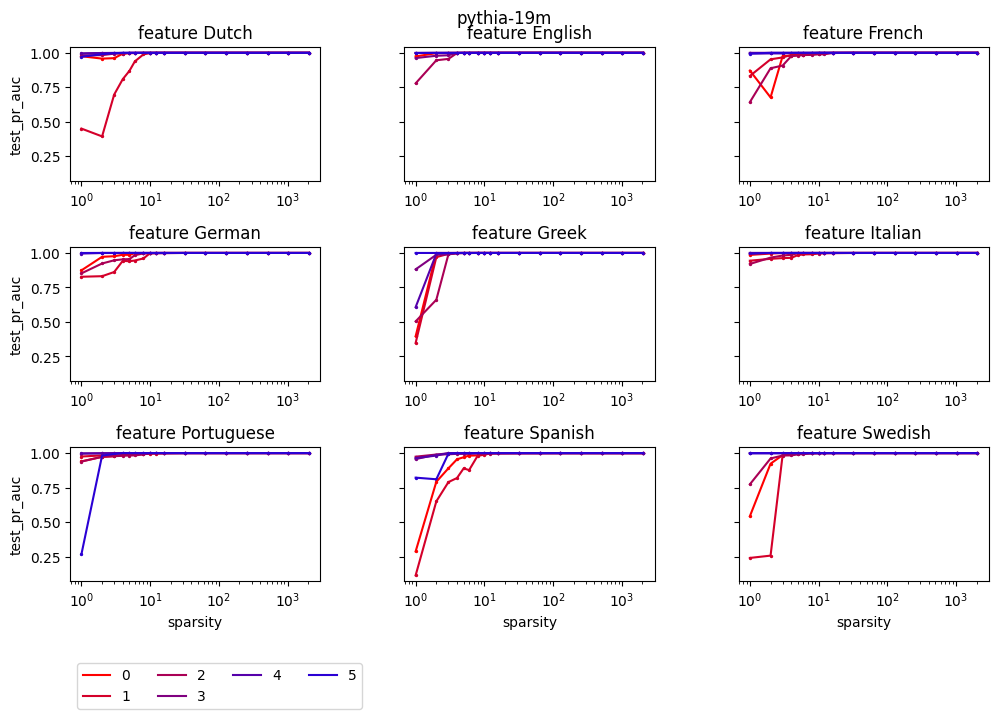

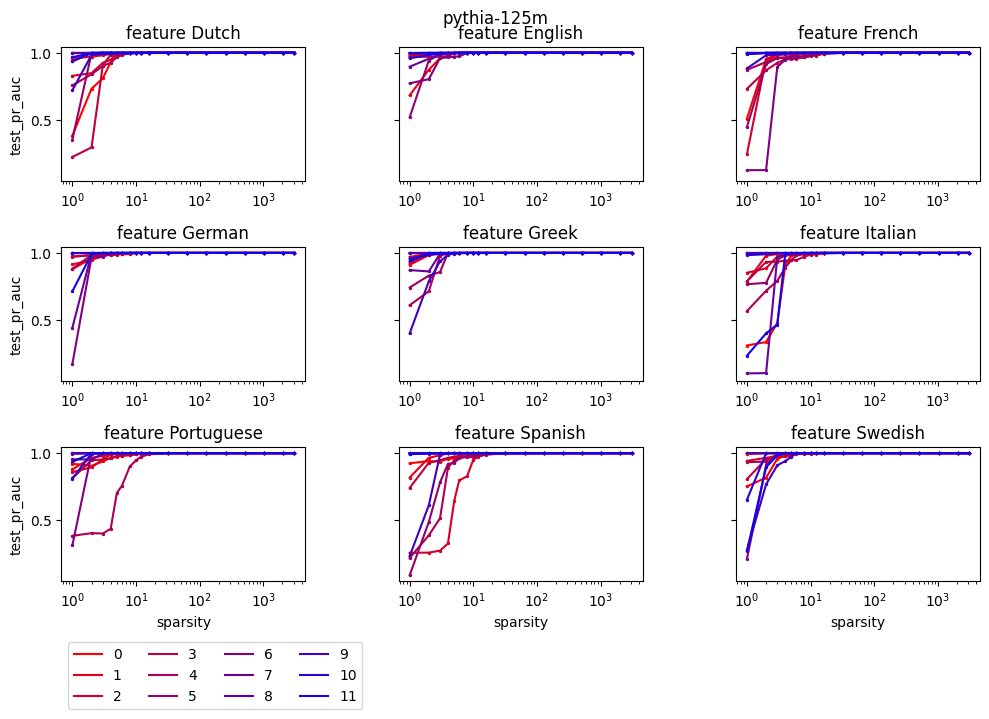

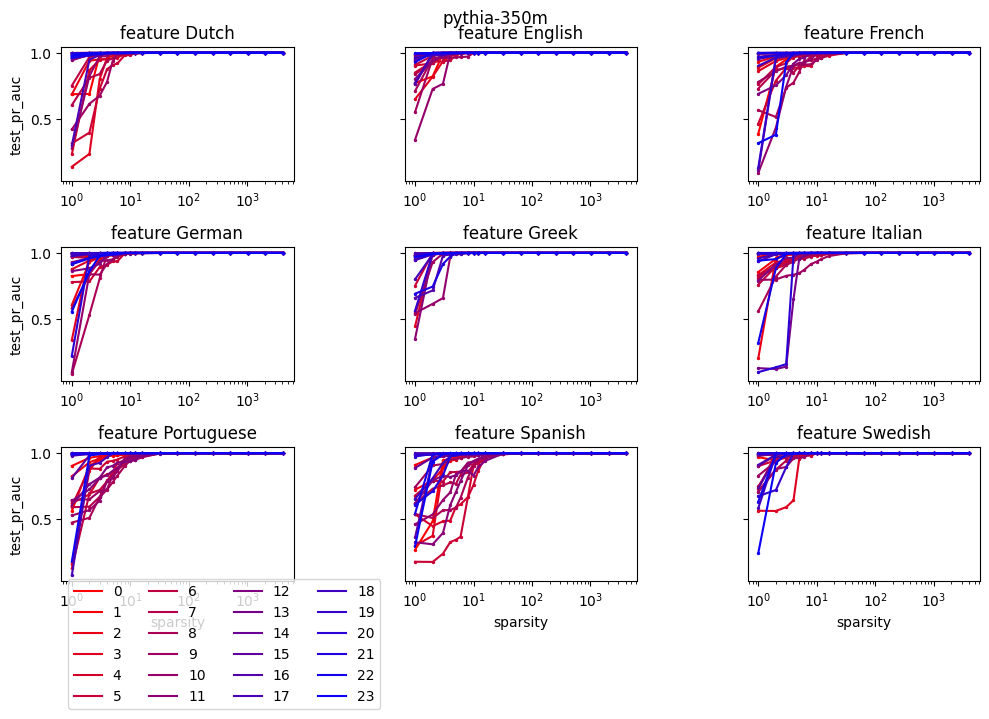

In [11]:
for s in sizes:
    plot_layer_metric_over_sparsity_per_feature(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)


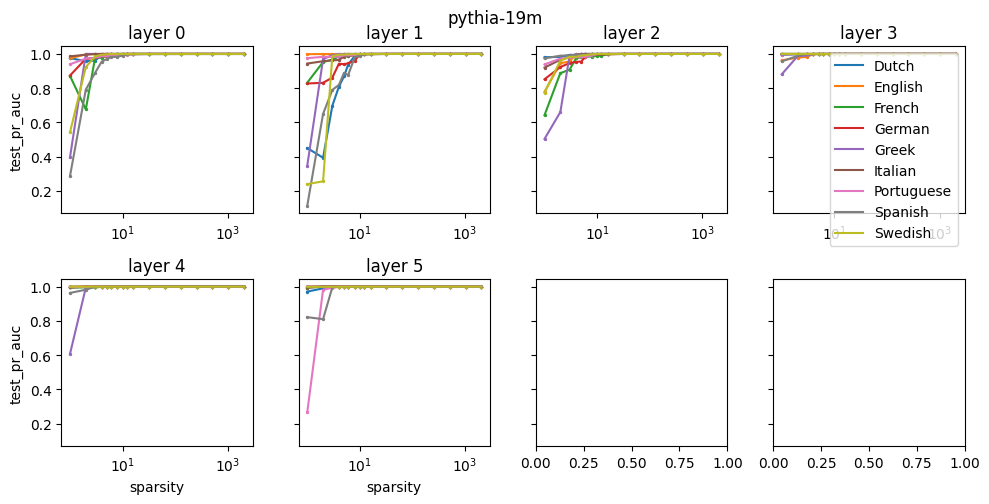

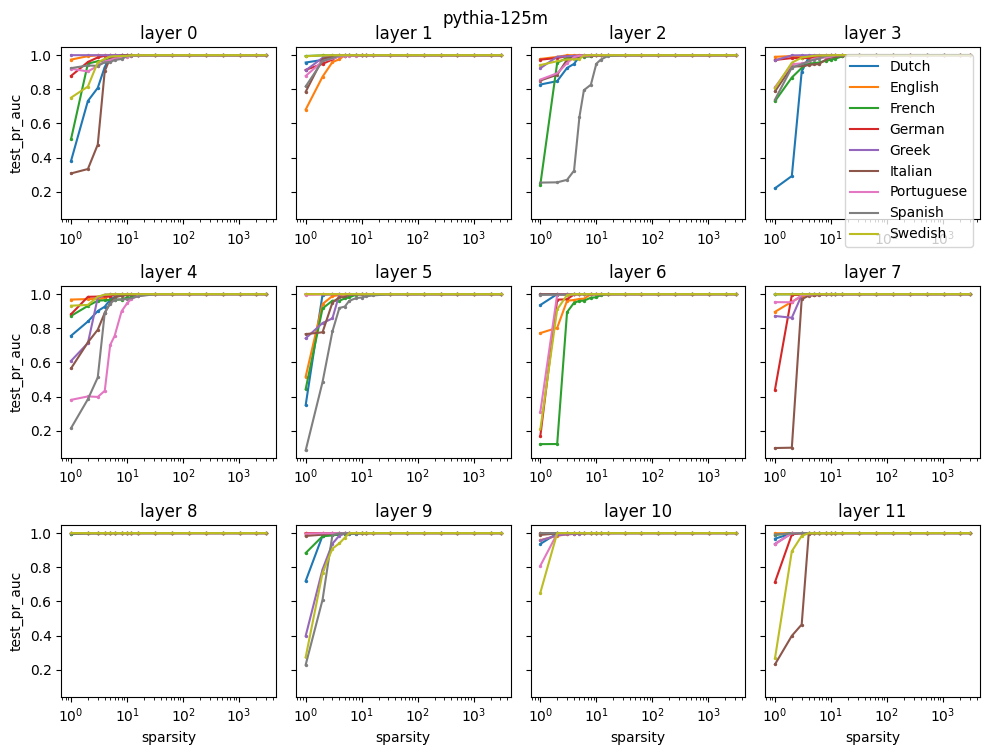

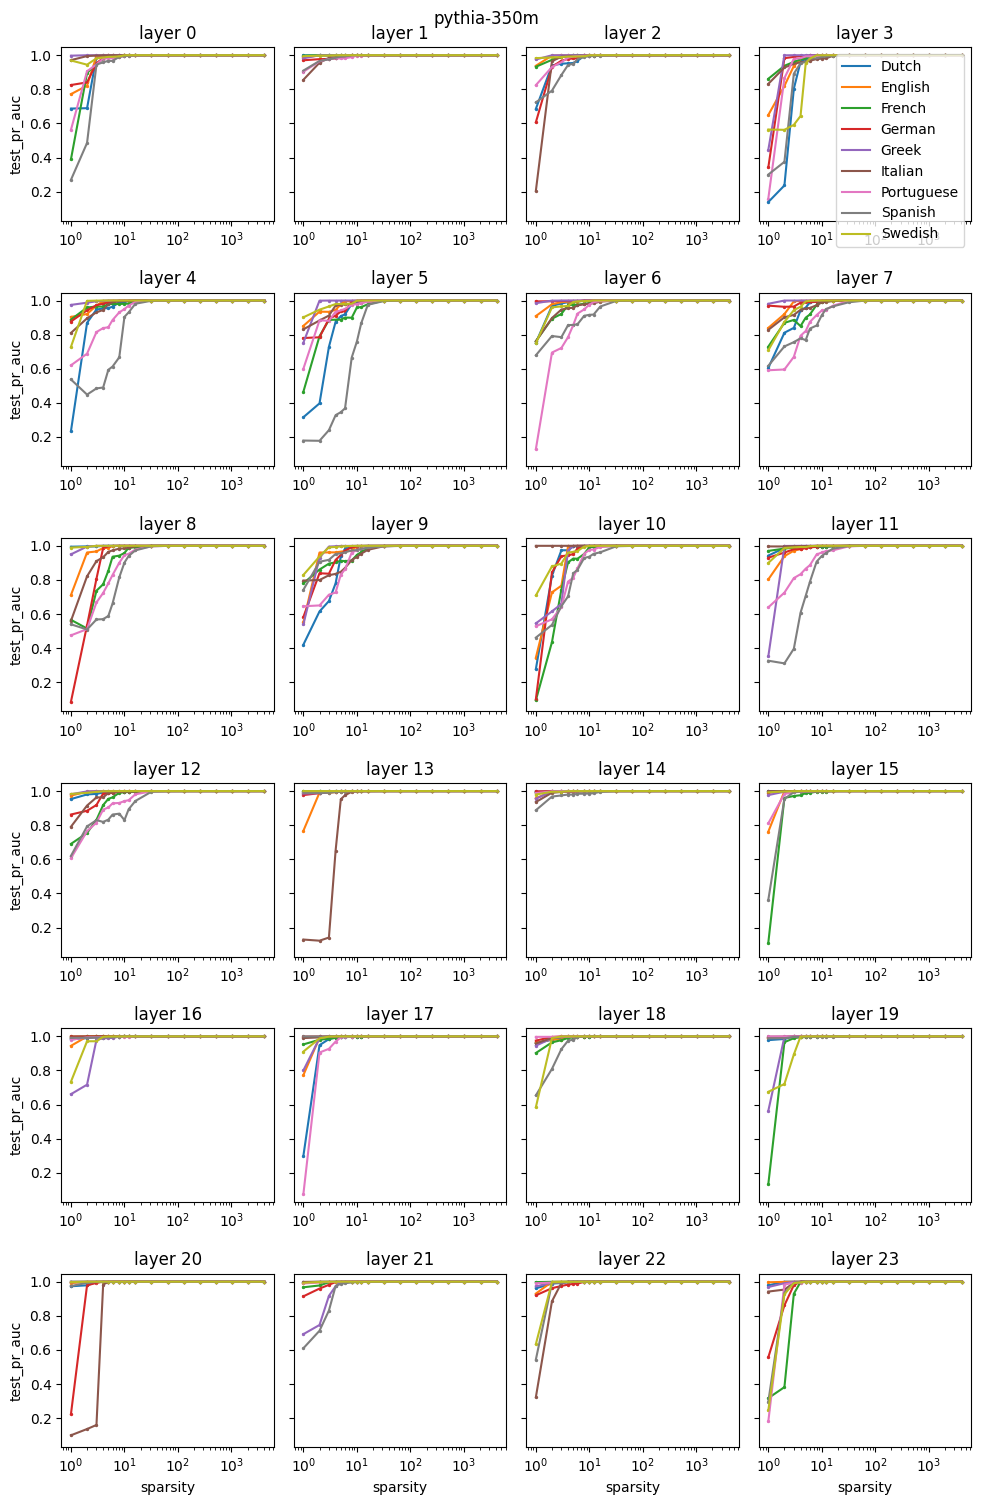

In [12]:
for s in sizes:
    plot_metric_over_sparsity_per_layer(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), 
    metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)

## Load activations of specific neurons

In [11]:
from activations.activation_subset import load_tensor, load_json
def load_activation_subset():
    '''
    Load the activation subset and metadata
    '''
    experiment_path = 'results/activation_subsets/pythia-19m/natural_lang_id.pyth.512.-1/europarl_monosemantic'
    activation_subset = load_tensor(os.path.join(
        experiment_path, 'activation_subset_dict.pt'))
    metadata = load_json(os.path.join(experiment_path, 'metadata.json'))
    return activation_subset, metadata
    
    
model_name = 'pythia-19m'
dataset_name = 'natural_lang_id.pyth.512.-1'
experiment_name = 'europarl_monosemantic'

act_subset_dict, metadata = load_activation_subset()
feature_dataset = load_feature_dataset(dataset_name)
model = load_model('pythia-19m') # only need tokenizer so load smallest model

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model pythia-19m into HookedTransformer


In [12]:

def plot_all_neuron_histograms(act_subset_dict, n_cols=5, logx=False):
    n = len(act_subset_dict)
    n_rows = math.ceil(n / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    for ix, (layer, neuron) in enumerate(act_subset_dict.keys()):
        activations = act_subset_dict[(layer, neuron)]
        ax = axs[ix//n_cols, ix%n_cols]
        ax.hist(activations[:, 1:].numpy().flatten(), bins=100)
        ax.set_title(f'Layer {layer}, Neuron {neuron}')
        if logx:
            ax.set_yscale('log')
    plt.tight_layout()


In [13]:
# def scaled_bins(activations, labels, n_bins=50):
#     _, bins = np.histogram(activations, bins=n_bins)
#     count_pos, _ = np.histogram(activations[labels], bins=bins)
#     count_neg, _ = np.histogram(activations[~labels], bins=bins)
#     dist_pos = count_pos / count_pos.sum()
#     dist_neg = count_neg / count_neg.sum()
#     return bins, dist_pos, dist_neg


def plot_all_neuron_histograms_by_class(act_subset_dict, activation_mask, label_dict, neuron_labels, n_cols=5, logx=False, plot_dist=False):
    n = len(act_subset_dict)
    n_rows = math.ceil(n / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), sharey=True)
    for ix, (layer, neuron) in enumerate(act_subset_dict.keys()):
        label = label_dict[(layer, neuron)]
        activations = act_subset_dict[(layer, neuron)]
        lang = neuron_labels[(layer, neuron)]
        ax = axs[ix//n_cols, ix%n_cols]
        if plot_dist:
            # normalize to get empirical distribution
            _, bins = np.histogram(activations, bins=50)
            count_pos, _ = np.histogram(activations[label][activation_mask[label]], bins=bins)
            count_neg, _ = np.histogram(activations[~label][activation_mask[~label]], bins=bins)
            dist_pos = count_pos / count_pos.sum()
            dist_neg = count_neg / count_neg.sum()

            ax.hist(bins[:-1], bins, weights=dist_pos, label=lang, alpha=0.5)
            ax.hist(bins[:-1], bins, weights=dist_neg, label='other', alpha=0.5)
            ax.set_ylim(0, 0.1)
        else:  # plot counts
            positive_activations = activations[label][activation_mask[label]]
            negative_activations = activations[~label][activation_mask[~label]]
            ax.hist(positive_activations.numpy(), bins=100, alpha=0.5, label=lang)
            ax.hist(negative_activations.numpy(), bins=100, alpha=0.5, label='other')
        
        ax.set_title(f'Layer {layer}, Neuron {neuron}')
        ax.legend(title='tokens')
        if logx:
            ax.set_yscale('log')

        if ix % n_cols == 0:
            ax.set_ylabel('empirical distribution' if plot_dist else 'count')
        if ix >= (n_rows - 1) * n_cols:
            ax.set_xlabel('activation')
            
    plt.tight_layout()


def plot_seq_mean_vs_max_activation(act_subset_dict, activation_mask, label_dict, neuron_labels, n_cols=5):
    n = len(act_subset_dict)
    n_rows = math.ceil(n / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    for ix, (layer, neuron) in enumerate(act_subset_dict.keys()):
        label = label_dict[(layer, neuron)]
        activations = act_subset_dict[(layer, neuron)]
        lang = neuron_labels[(layer, neuron)]
        ax = axs[ix//n_cols, ix%n_cols]
        # TODO: fix with [activation_mask[label]]
        ax.scatter(activations[label].numpy().mean(axis=1),
                   activations[label].numpy().max(axis=1),
                   label=lang, alpha=0.1, s=2, zorder=2)
        ax.scatter(activations[~label].numpy().mean(axis=1),
                   activations[~label].numpy().max(axis=1),
                   label='other', alpha=0.05, s=1)
        
        ax.set_title(f'Layer {layer}, Neuron {neuron}')
        ax.legend(title='sequence')

        if ix >= (n_rows - 1) * n_cols:
            ax.set_xlabel('mean activation')

        if ix % n_cols == 0:
            ax.set_ylabel('max activation')
            
    plt.tight_layout()




In [14]:
interp_neurons = rdf.query('k==1 and model_size=="19m"').sort_values('test_pr_auc', ascending=False).head(10).reset_index()[['feature', 'layer', 'support']].values
neuron_labels = {(l, n[0]): f for f, l, n in interp_neurons}
lang_arr = np.array(feature_dataset['lang'])
lang_arr = np.array(list(map(lambda x: NATURAL_LANGS_UNABBREVIATED[x], lang_arr)))
label_dict = {k: lang_arr == v for k, v in neuron_labels.items()}
for k in label_dict.keys():
    if k not in act_subset_dict:
        del act_subset_dict[k]
activation_mask = feature_dataset['tokens'] > 1


Text(0.5, 1.02, 'pythia-19m interpretable language neurons')

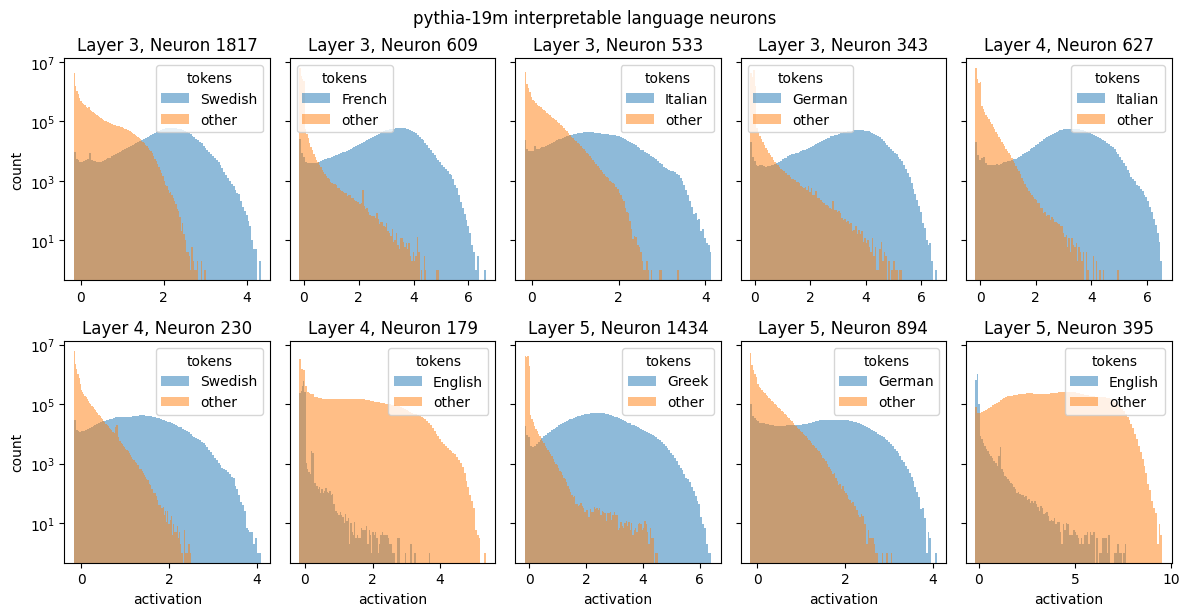

In [23]:
plot_all_neuron_histograms_by_class(act_subset_dict, activation_mask, label_dict, neuron_labels, logx=True)
plt.suptitle('pythia-19m interpretable language neurons', y=1.02)

Text(0.5, 1.02, 'pythia-19m interpretable language neurons')

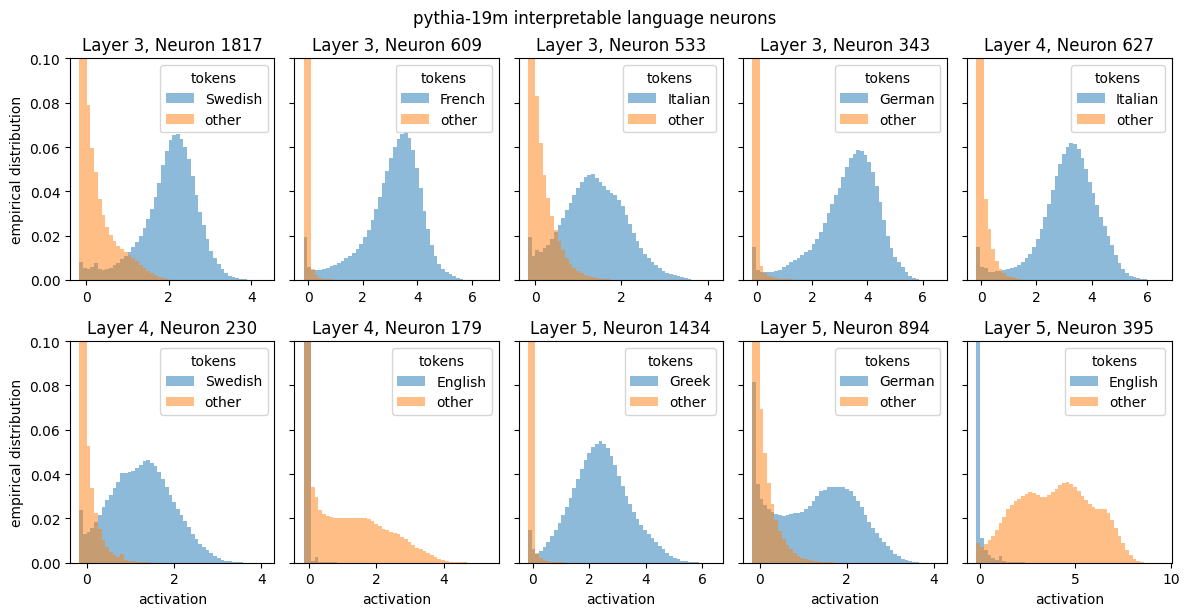

In [24]:
plot_all_neuron_histograms_by_class(act_subset_dict, activation_mask, label_dict, neuron_labels, plot_dist=True)
plt.suptitle('pythia-19m interpretable language neurons', y=1.02)

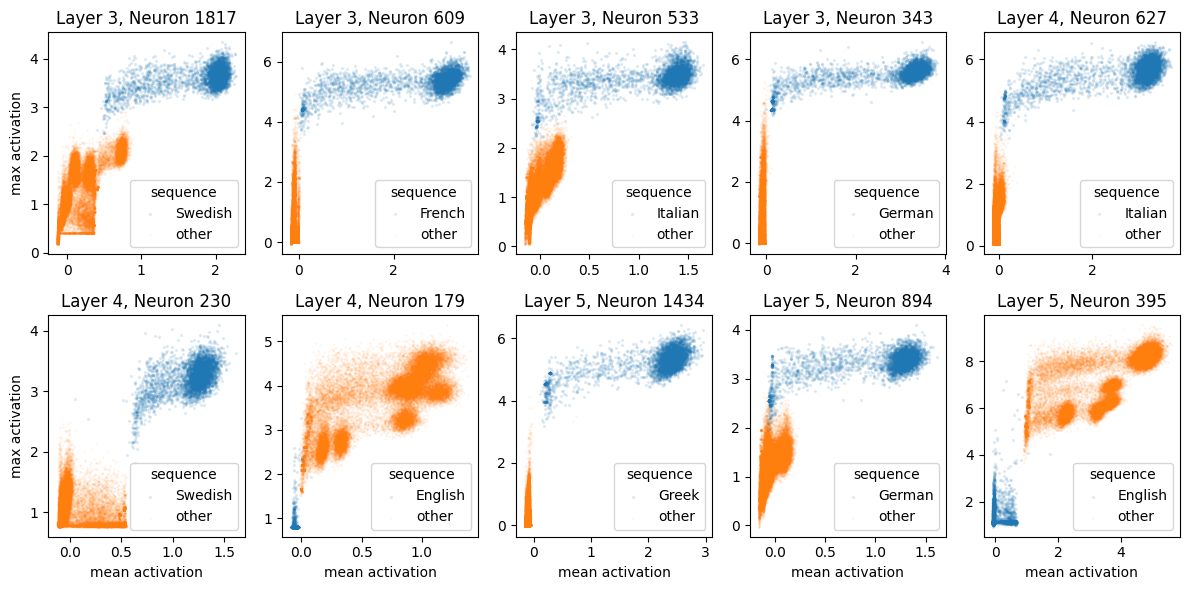

In [25]:
plot_seq_mean_vs_max_activation(act_subset_dict, activation_mask, label_dict, neuron_labels)

In [27]:
# get activation statistics for each token in the vocabulary
feature, layer, neuron = 'French', 3, 609
tokens = feature_dataset['tokens']
activations = act_subset_dict[(layer, neuron)]
n, ctx_len = activations.shape
token_labels = np.repeat(label_dict[(layer, neuron)][:, None], ctx_len, axis=1)

activation_df = pd.DataFrame({
    'token': tokens.flatten(), 
    'activation': activations.flatten(),
    'label': token_labels.flatten()
})
vocab_df = activation_df.groupby(['token', 'label']).describe()['activation']


In [75]:
df = vocab_df.unstack().fillna(0)
df['str'] = [model.tokenizer.decode(t) for t in df.index.values]

In [76]:
# todo & (df['str'].str.len() > 3) does not work
total_count = df['count'].sum(axis=1)
common_df = df.loc[(df['count', True] > 200) & (df['count', False] > 200)]

In [32]:
common_df

count                mean                 std                 min  \
label      False      True     False      True     False      True     False   
token                                                                          
0      2258333.0  296337.0 -0.164171 -0.164181  0.000170  0.000199 -0.165636   
1        32808.0    4144.0 -0.166929 -0.166929  0.000000  0.000000 -0.166929   
2         7328.0     232.0 -0.061157  2.240090  0.060462  0.435630 -0.169969   
3         3616.0     703.0 -0.118743  1.804374  0.044328  0.615747 -0.169971   
8        29758.0   55919.0 -0.078772  3.362402  0.188549  0.436653 -0.169971   
...          ...       ...       ...       ...       ...       ...       ...   
47610      555.0     244.0 -0.108873  3.881261  0.081958  0.475952 -0.169971   
48104      728.0     286.0 -0.108217  1.801307  0.031550  0.391144 -0.169901   
49446      398.0     222.0 -0.158268  3.156258  0.029900  0.286298 -0.169971   
49981      513.0     590.0  0.093823  4.142904  0.171203  0.318389 -0.169908   
50276     2338.0     274.0 -0.125506  0.449814  0.060245  0.364092 -0.169971   

                      25%                 50%                 75%            \
label      True     False      True     False      True     False      True   
token                                                                         
0     -0.165608 -0.164239 -0.164268 -0.164149 -0.164164 -0.164053 -0.164042   
1     -0.166929 -0.166929 -0.166929 -0.166929 -0.166929 -0.166929 -0.166929   
2      0.654635 -0.121118  1.990158 -0.045468  2.292524 -0.001626  2.541555   
3     -0.169721 -0.155446  1.475988 -0.127607  1.897413 -0.093854  2.210289   
8     -0.020333 -0.136687  3.103993 -0.100815  3.360151 -0.057435  3.628326   
...         ...       ...       ...       ...       ...       ...       ...   
47610  0.589672 -0.131020  3.575265 -0.114044  3.969160 -0.097013  4.191550   
48104 -0.162498 -0.132018  1.610635 -0.109780  1.858905 -0.082507  2.033199   
49446  0.998816 -0.168905  3.014045 -0.164428  3.158177 -0.155935  3.350214   
49981  1.301052 -0.005998  4.002113  0.085349  4.140548  0.170637  4.300596   
50276 -0.168630 -0.165511  0.182447 -0.148854  0.421728 -0.107664  0.653909   

            max                      str  
label     False      True                 
token                                     
0     -0.163571 -0.163858  <|endoftext|>  
1     -0.166929 -0.166929    <|padding|>  
2      0.018861  3.228180              !  
3      0.527804  3.283060              "  
8      4.097181  5.816283              '  
...         ...       ...            ...  
47610  1.570933  5.066278           ront  
48104 -0.029024  2.580049         Lisbon  
49446  0.355303  3.721400          confl  
49981  1.468864  5.052130          iveau  
50276  0.328467  2.011759                 

[826 rows x 17 columns]

In [33]:
activation_df['random'] = np.random.permutation(activation_df['token'])

In [34]:
vocab_df.sort_values('mean')

,,count,mean,std,min,25%,50%,75%,max
token,label,,,,,,,,
36269,False,1.0,-0.169971,NaN,-0.169971,-0.169971,-0.169971,-0.169971,-0.169971
24825,False,1.0,-0.169971,NaN,-0.169971,-0.169971,-0.169971,-0.169971,-0.169971
21817,False,1.0,-0.169971,NaN,-0.169971,-0.169971,-0.169971,-0.169971,-0.169971
15862,False,1.0,-0.169971,NaN,-0.169971,-0.169971,-0.169971,-0.169971,-0.169971
44639,False,1.0,-0.169971,NaN,-0.169971,-0.169971,-0.169971,-0.169971,-0.169971
...,...,...,...,...,...,...,...,...,...
37179,True,932.0,5.067233,0.348896,2.443842,4.885628,5.097511,5.307576,6.007998
4591,True,2674.0,5.134374,0.558865,0.734820,5.036417,5.243218,5.426288,6.312261
24241,True,1118.0,5.222908,0.353562,-0.128837,5.045527,5.233143,5.401591,6.169356


In [79]:
most_dif = common_df.loc[
    (common_df['mean', True] - common_df['mean', False]).sort_values(ascending=False).index
]
most_dif = most_dif.loc[most_dif['str'].str.len() > 2].head(15)#[['count', 'mean', 'str']]

In [80]:
most_dif

count              mean                 std                 min  \
label    False    True     False      True     False      True     False   
token                                                                      
5139     379.0  5191.0  0.017003  5.051188  0.172748  0.524620 -0.169971   
425     3591.0  4847.0 -0.040330  4.741588  0.193977  0.471068 -0.169971   
13460    827.0   313.0 -0.078345  4.620319  0.150197  0.542801 -0.169971   
383     5298.0  4384.0 -0.086753  4.594529  0.086735  0.922298 -0.169971   
12661    311.0   226.0 -0.101594  4.520814  0.035405  0.617684 -0.169961   
29350    414.0   488.0  0.112930  4.690269  0.363327  0.651847 -0.169955   
4981    1653.0   470.0 -0.113900  4.394014  0.113864  0.297648 -0.169971   
5047    1500.0   250.0 -0.115373  4.374394  0.074310  0.920918 -0.169971   
14642    768.0  2436.0  0.205214  4.657535  0.254600  0.403408 -0.137128   
621      708.0  1685.0 -0.099712  4.332163  0.080886  0.687855 -0.169971   
4164   15242.0  2855.0 -0.146058  4.271291  0.056518  0.516103 -0.169971   
1899     606.0   393.0 -0.136300  4.231258  0.037025  0.559506 -0.169971   
7460     426.0  7970.0 -0.085437  4.277785  0.359739  0.417817 -0.169970   
15923    846.0  1581.0  0.042606  4.366126  0.343357  0.499266 -0.169967   
11090   1203.0  1840.0 -0.116362  4.162886  0.100295  0.526620 -0.169969   

                      25%                 50%                 75%            \
label      True     False      True     False      True     False      True   
token                                                                         
5139  -0.168845 -0.103819  4.881117 -0.023069  5.131753  0.082585  5.342410   
425    0.169044 -0.166369  4.526395 -0.146635  4.775366  0.010944  5.015157   
13460  0.864193 -0.164731  4.488328 -0.148462  4.693751 -0.032216  4.897946   
383   -0.169646 -0.144576  4.316672 -0.090744  4.878571 -0.049392  5.187678   
12661 -0.016833 -0.127764  4.250422 -0.105780  4.658945 -0.072697  4.893216   
29350 -0.157983 -0.084250  4.566102 -0.017689  4.823666  0.135220  5.031458   
4981   1.773853 -0.161467  4.236408 -0.140798  4.423471 -0.104762  4.569611   
5047   0.034870 -0.156308  4.150318 -0.132639  4.562267 -0.099160  4.959684   
14642 -0.143023  0.081860  4.514844  0.162779  4.692406  0.258979  4.861657   
621   -0.165523 -0.162554  3.871033 -0.140051  4.449490 -0.008634  4.830438   
4164  -0.157413 -0.165249  4.100389 -0.155285  4.337143 -0.139200  4.550325   
1899  -0.098040 -0.164495  4.034640 -0.148193  4.302009 -0.118850  4.515008   
7460  -0.157803 -0.168286  4.060993 -0.159734  4.319273 -0.133427  4.542508   
15923  0.068962 -0.120618  4.095746 -0.048253  4.430425  0.078462  4.722181   
11090 -0.168994 -0.141343  4.030167 -0.127989  4.232689 -0.113293  4.414734   

            max                  str  
label     False      True             
token                                 
5139   1.076159  6.641057         je  
425    2.072834  6.325641         ne  
13460  1.603203  5.548356         va  
383    1.994722  6.192281        est  
12661 -0.024419  5.491771    propose  
29350  1.597610  5.789506        vez  
4981   2.193905  5.195961       util  
5047   1.159254  5.499024       rend  
14642  2.330356  5.658634        ont  
621    0.480382  5.753550       ions  
4164   2.214700  5.399063         il  
1899  -0.004183  5.429012   position  
7460   3.678138  6.080485        qui  
15923  3.066646  5.478084       bien  
11090  2.254127  5.297505         Il

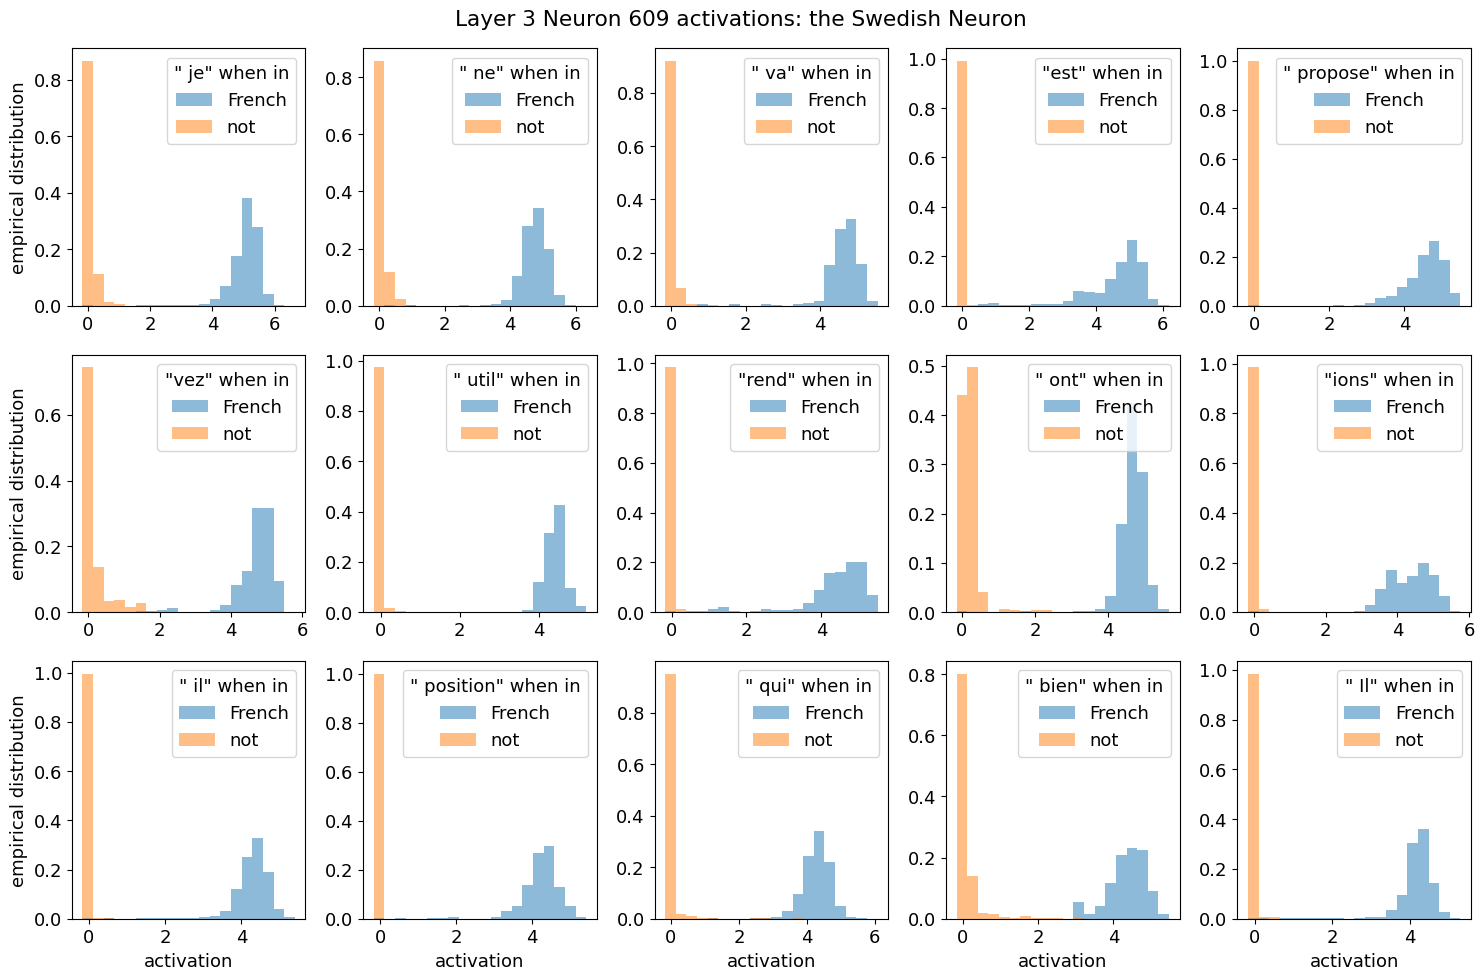

In [82]:
# make plot fontsize bigger
plt.rcParams.update({'font.size': 13})

feature, layer, neuron = 'French', 3, 609

most_dif_tokens = most_dif.index.values
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for ix, t in enumerate(most_dif_tokens):
    ax = axs[ix // 5, ix % 5]
    token_activation_df = activation_df.query('token==@t')
    t_activations = token_activation_df.activation.values
    t_labels = token_activation_df.label.values

    _, bins = np.histogram(t_activations, bins=20)
    count_pos, _ = np.histogram(t_activations[t_labels], bins=bins)
    count_neg, _ = np.histogram(t_activations[~t_labels], bins=bins)
    dist_pos = count_pos / count_pos.sum()
    dist_neg = count_neg / count_neg.sum()
    ax.hist(bins[:-1], bins, weights=dist_pos, label='French', alpha=0.5)
    ax.hist(bins[:-1], bins, weights=dist_neg, label='not', alpha=0.5)
    ax.legend(title=f'"{most_dif.str[t]}" when in')

    if ix % 5 == 0:
        ax.set_ylabel('empirical distribution')
    if ix >= 10:
        ax.set_xlabel('activation')
    # ax.set_title(f'activation of "{most_dif.str[t]}"')
plt.suptitle(f'Layer {layer} Neuron {neuron} activations: the Swedish Neuron')
plt.tight_layout()


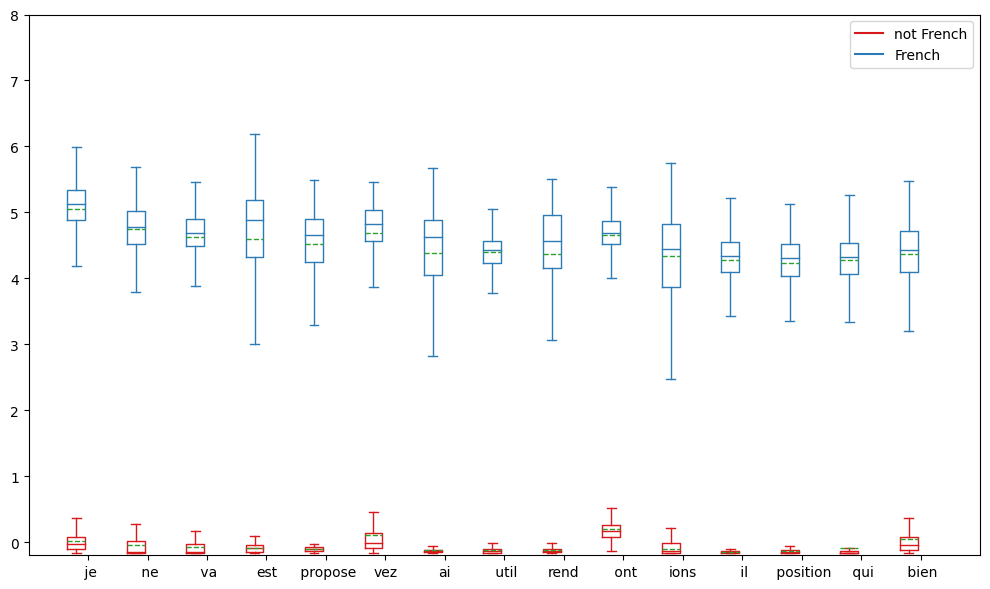

In [70]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = [model.tokenizer.decode(t) for t in most_dif_tokens]

fig, ax = plt.subplots(figsize=(10, 6))
negative_activations = [activation_df.query('label==False and token==@t').activation.values for t in most_dif_tokens]
positive_activations = [activation_df.query('label==True and token==@t').activation.values for t in most_dif_tokens]

n_tokens = len(most_dif_tokens)
positions=np.array(np.arange(n_tokens))*2.0-0.4

bpl = ax.boxplot(negative_activations, positions=positions, sym='', widths=0.6, meanline=True, showmeans=True)
bpr = ax.boxplot(positive_activations, positions=positions, sym='', widths=0.6, meanline=True, showmeans=True)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
ax.plot([], c='#D7191C', label='not French')
ax.plot([], c='#2C7BB6', label='French')
ax.legend(loc='upper right')

ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_xlim(-2, len(ticks)*2)
ax.set_ylim(-0.2, 8)
plt.tight_layout()

In [ ]:
NATURAL_LANGS_UNABBREVIATED

## Look at dataset examples

In [64]:
def prepare_colored_tokens_data(feature_dataset, tokenizer, act_subset_dict, neuron, lang, n=100):
    # decode tokens exactly as they appear in the raw text
    def decode_tokens(tokens):
        return [tokenizer.decode([t]) for t in tokens if t > 1]

    def non_trivial_activation_list(token_vector, activation_vector):
        return activation_vector[token_vector > 1].tolist()

    lang_list = np.where(np.array(feature_dataset['lang']) == lang)[0][:n]

    token_list = [decode_tokens(feature_dataset['tokens'][i]) 
        for i in lang_list]

    activation_list = [
        non_trivial_activation_list(
            feature_dataset['tokens'][i], act_subset_dict[neuron][i])
        for i in lang_list
    ]
    formatted_activation_list = [[[[t]] for t in seq] for seq in activation_list]
    return token_list, formatted_activation_list

#print(''.join(token_list[5]))

In [83]:
n=10
lang = 'fr'
neuron = (3, 609)
token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [84]:
from circuitsvis.tokens import colored_tokens
ix=6
colored_tokens(token_list[ix], activation_list[ix])

In [64]:
n=10
lang = 'en'
neuron = (5, 1434)
# There is a bug, exercise to the reader fix it
token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [81]:
ix=1
colored_tokens(token_list[ix], activation_list[ix])

In [55]:
n=100
lang = 'Go'
neuron = (1, 884)

token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [56]:
ix=4
colored_tokens(token_list[ix], activation_list[ix])

In [57]:
n=100
lang = 'Java'
neuron = (6, 4070)

token_list, activation_list = prepare_colored_tokens_data(feature_dataset, model.tokenizer, act_subset_dict, neuron, lang, n=100)

In [58]:
ix=3
colored_tokens(token_list[ix], activation_list[ix])

In [ ]:
# ignore 

n_layers = rdf.reset_index().groupby('model_size').layer.max().to_dict()

one_sp = rdf.query('k==1').sort_values('test_pr_auc', ascending=False).head(10)
# plot one_sp for each feature:
# x axis: normalized layer depth
# y axis: test_pr_auc
# color: model size
def plot_model_k_sparse_performance_by_feature_and_depth(rdf, k, metric):
    features = rdf.index.get_level_values('feature').unique()
    fig, axs = plt.subplots(math.ceil(len(features) / 3), 3, figsize=(15, 10), sharey=True)
    for ix, f in enumerate(features):
        ax = axs[ix // 3, ix % 3]
        for s in sizes:
            line = rdf.loc[s, f, :, k][metric]
            y = line.values
            x = line.index / n_layers[s]
            ax.plot(x, y, label=s)
        
        ax.set_title(f)
        ax.set_xlabel('Normalized layer depth')
        ax.set_ylabel(metric)
    ax.legend()
    plt.tight_layout()
    plt.suptitle(f'Best {k}-sparse performance by feature and depth', y=1.02)

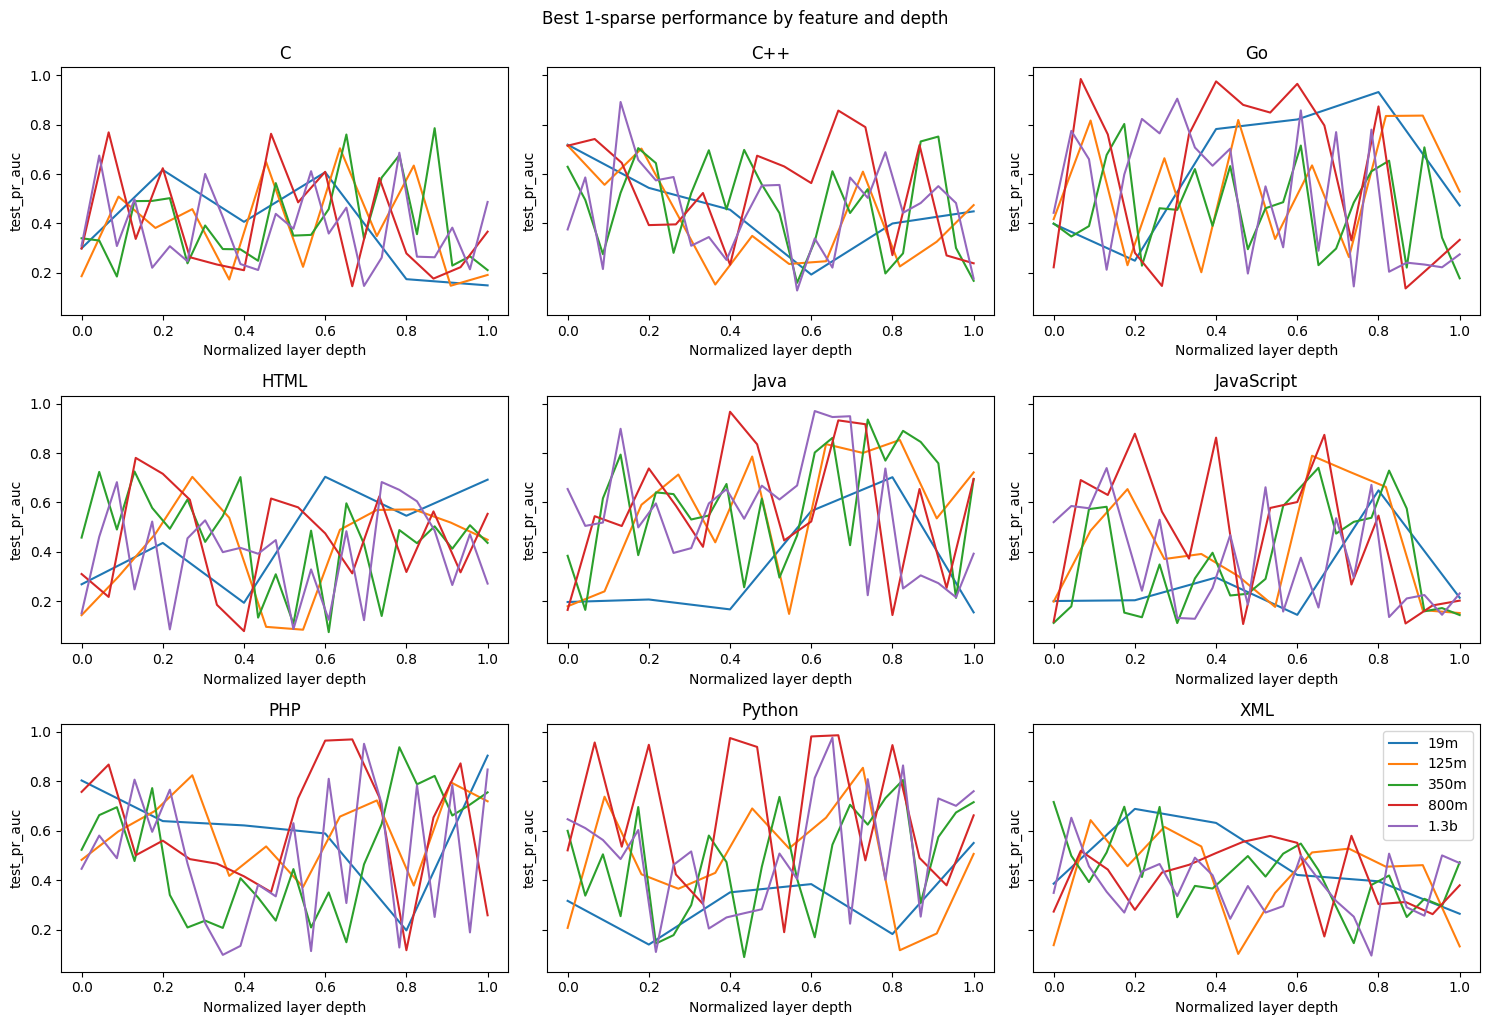

In [ ]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 1, 'test_pr_auc')

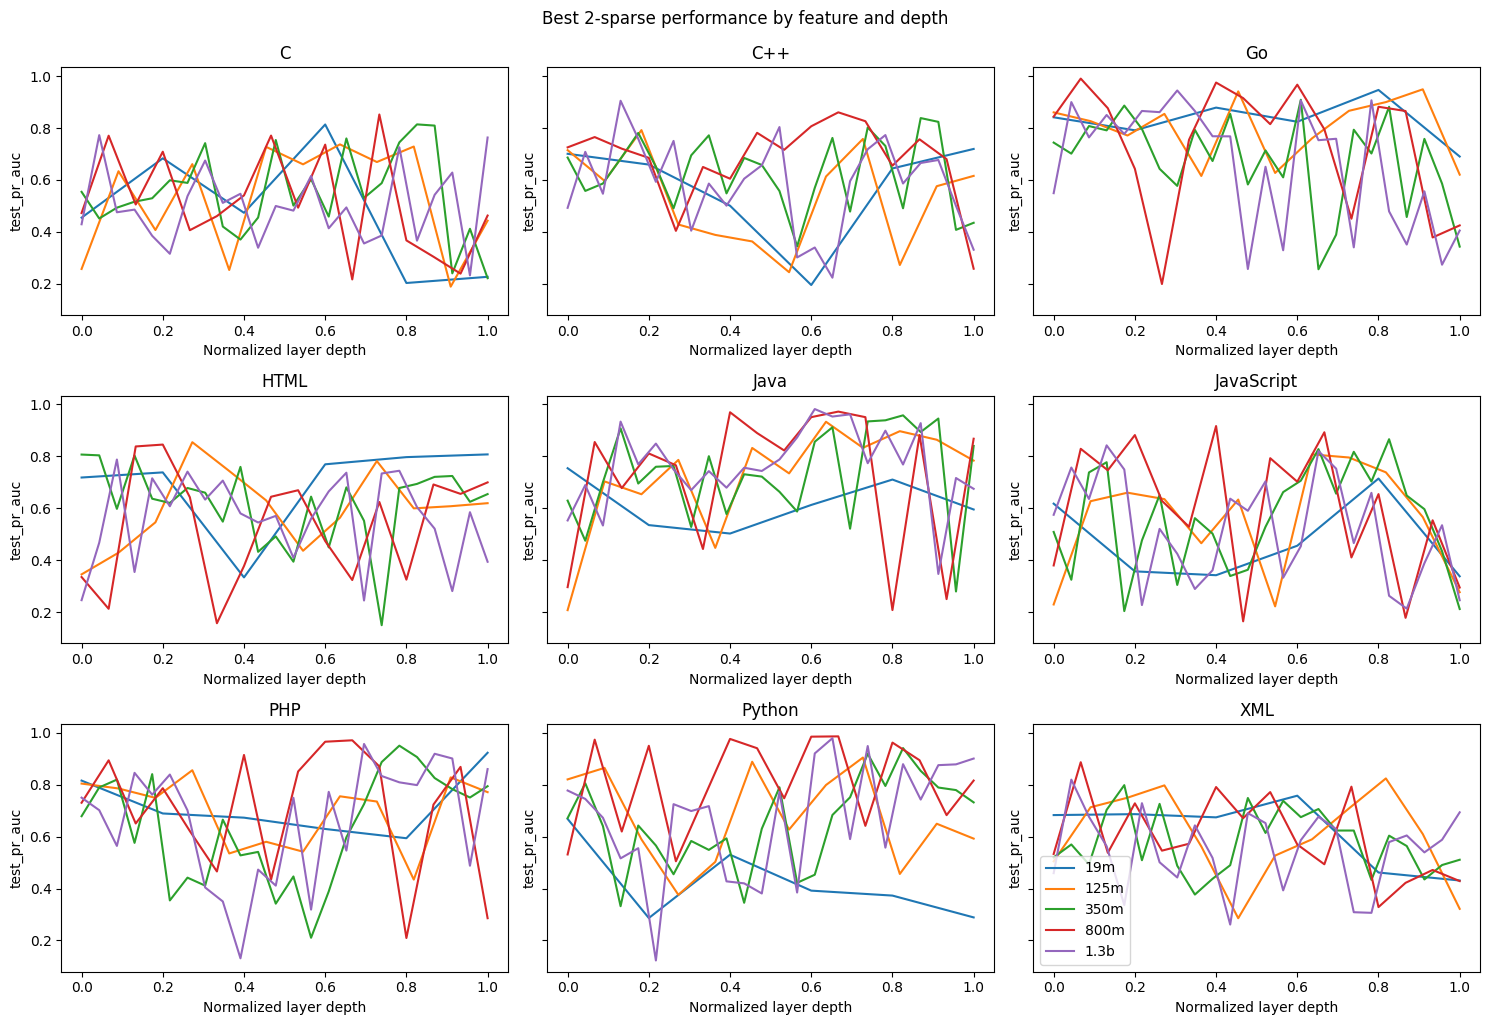

In [ ]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 2, 'test_pr_auc')